In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [3]:
import kagglehub
kagglehub.login()

In [4]:
the_future_crop_challenge_path = kagglehub.competition_download('the-future-crop-challenge')
print("data import successfully")

data import successfully


In [5]:
def load_data(crop: str, mode: str="train"):
    base_path = the_future_crop_challenge_path

    tasmax = pd.read_parquet(f"{base_path}/tasmax_{crop}_{mode}.parquet")
    tasmin = pd.read_parquet(f"{base_path}/tasmin_{crop}_{mode}.parquet")
    pr = pd.read_parquet(f"{base_path}/pr_{crop}_{mode}.parquet")
    rsds = pd.read_parquet(f"{base_path}/rsds_{crop}_{mode}.parquet")
    soil_co2 = pd.read_parquet(f"{base_path}/soil_co2_{crop}_{mode}.parquet")

    target = None
    if mode == "train":
        target = pd.read_parquet(f"{base_path}/train_solutions_{crop}.parquet")

    return {
        'tasmax': tasmax,
        'tasmin': tasmin,
        'pr': pr,
        'rsds': rsds,
        'soil_co2': soil_co2,
        'target': target,
    }

In [23]:
feature_maize

,tasmax_mean,tasmax_max,tasmax_min,tasmax_std,tasmin_mean,tasmin_max,tasmin_min,tasmin_std,pr_mean,pr_max,...,rsds_min,rsds_std,crop,year,lon,lat,texture_class,real_year,co2,nitrogen
ID,,,,,,,,,,,,,,,,,,,,,
0,17.839436,29.090820,4.201721,5.273438,8.632730,14.806366,-3.116882,3.260431,0.000043,0.000457,...,5.591039,90.259311,maize,381.0,-122.25,48.25,9.0,1982,340.79,186.110992
1,16.734991,27.898071,2.099579,5.440257,7.719133,14.462341,-5.306366,3.538944,0.000048,0.000629,...,5.754406,89.745583,maize,381.0,-122.25,48.75,9.0,1982,340.79,186.110992
2,16.004420,28.686737,0.422302,6.039337,7.395196,15.773743,-8.419312,4.045676,0.000083,0.000977,...,3.781173,89.038533,maize,381.0,-122.25,49.25,9.0,1982,340.79,184.934006
3,20.881835,36.500885,-0.738281,9.764356,5.692856,17.426544,-12.058136,6.111002,0.000016,0.000162,...,26.691336,101.988291,maize,381.0,-116.75,43.25,9.0,1982,340.79,186.110992
4,22.615727,37.733215,-0.096375,9.605713,7.982770,19.343414,-10.309570,5.960675,0.000015,0.000203,...,19.430513,103.514785,maize,381.0,-116.75,43.75,10.0,1982,340.79,186.110992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349714,18.528323,33.398590,-7.685638,10.676819,8.551638,22.149750,-16.150940,10.141844,0.000024,0.000343,...,17.483034,75.899524,maize,419.0,132.75,46.75,9.0,2020,414.89,221.811996
349715,18.352557,33.134186,-8.825165,10.733707,8.365118,22.621735,-16.659058,10.170843,0.000024,0.000392,...,28.723750,75.370455,maize,419.0,132.75,47.25,9.0,2020,414.89,221.811996
349716,19.024050,32.286957,-8.187988,9.448358,9.654589,23.300964,-15.566376,9.549049,0.000028,0.000425,...,33.978424,72.468355,maize,419.0,133.25,45.25,9.0,2020,414.89,1.846000


In [6]:
# Load training data for maize
maize_train = load_data("maize", "train")

In [7]:
def aggregate_daily_data(df):
    numeric_df = df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
    return numeric_df.agg(['mean', 'max', 'min', 'std'], axis=1)
tasmax_agg_maize = aggregate_daily_data(maize_train['tasmax'])
tasmin_agg_maize = aggregate_daily_data(maize_train['tasmin'])
pr_agg_maize = aggregate_daily_data(maize_train['pr'])
rsds_agg_maize = aggregate_daily_data(maize_train['rsds'])
tasmax_agg_maize.columns = [f'tasmax_{col}' for col in tasmax_agg_maize.columns]
tasmin_agg_maize.columns = [f'tasmin_{col}' for col in tasmin_agg_maize.columns]
pr_agg_maize.columns = [f'pr_{col}' for col in pr_agg_maize.columns]
rsds_agg_maize.columns = [f'rsds_{col}' for col in rsds_agg_maize.columns]

feature_maize = pd.concat([tasmax_agg_maize, tasmin_agg_maize, pr_agg_maize, rsds_agg_maize, maize_train['soil_co2']], axis = 1)
target_maize = maize_train['target']

In [9]:
# Drop non-numeric columns
numeric_features_maize = feature_maize.select_dtypes(include=[np.number])

# Scale features
scaler_maize = StandardScaler()
features_scaled_maize = scaler_maize.fit_transform(numeric_features_maize)

In [10]:
# Get the year column
year_series = maize_train['tasmax']['year']

# Use the maximum year as validation year
val_year = year_series.max()
print(f"Using year {val_year} as validation set")

# Create boolean mask for validation
val_mask = (year_series == val_year)

# Split data
X_train = features_scaled_maize[~val_mask]
X_val = features_scaled_maize[val_mask]
y_train = target_maize[~val_mask].values.ravel()
y_val = target_maize[val_mask].values.ravel()


Using year 419.0 as validation set


In [11]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

In [12]:
xgb_model.fit(X_train, y_train)
# Predict
y_pred = xgb_model.predict(X_val)
# Evaluation
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"XGBoost Validation RMSE: {rmse:.4f}")
print(f"XGBoost Validation R2: {r2:.4f}")

XGBoost Validation RMSE: 1.1253
XGBoost Validation R2: 0.7911


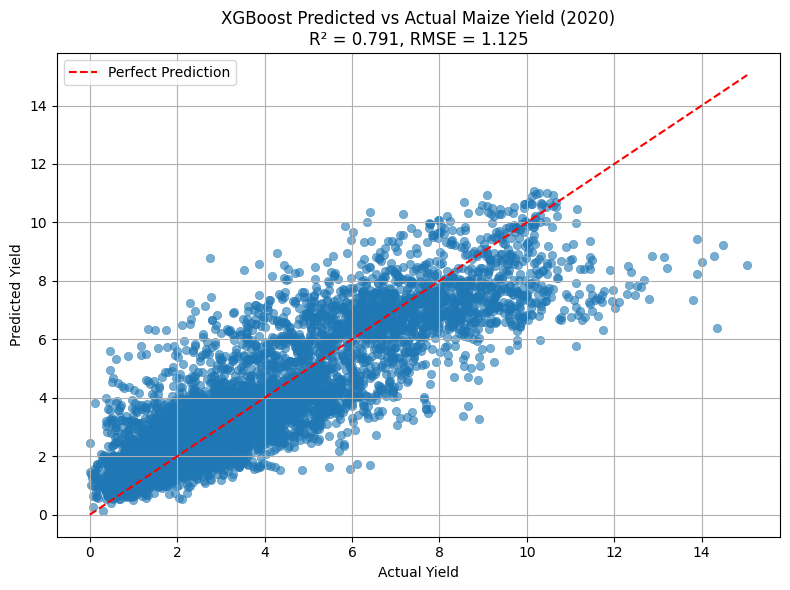

In [13]:
# Plot Predicted vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title(f"XGBoost Predicted vs Actual Maize Yield (2020)\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


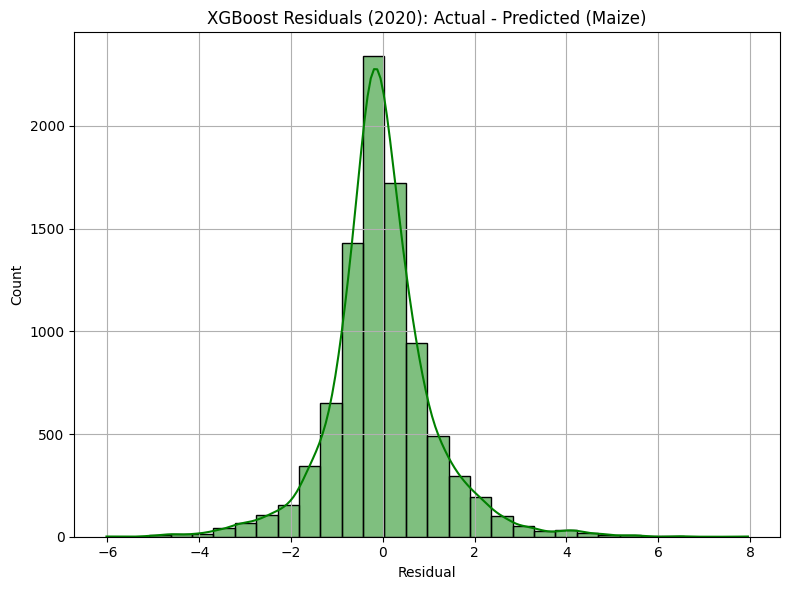

In [14]:
residuals = y_val - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.title("XGBoost Residuals (2020): Actual - Predicted (Maize)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Load test data
maize_test = load_data("maize", "test")

tasmax_agg_test = aggregate_daily_data(maize_test['tasmax'])
tasmax_agg_test.columns = [f'tasmax_{col}' for col in tasmax_agg_test.columns]

tasmin_agg_test = aggregate_daily_data(maize_test['tasmin'])
tasmin_agg_test.columns = [f'tasmin_{col}' for col in tasmin_agg_test.columns]

pr_agg_test = aggregate_daily_data(maize_test['pr'])
pr_agg_test.columns = [f'pr_{col}' for col in pr_agg_test.columns]

rsds_agg_test = aggregate_daily_data(maize_test['rsds'])
rsds_agg_test.columns = [f'rsds_{col}' for col in rsds_agg_test.columns]

features_test = pd.concat([tasmax_agg_test, tasmin_agg_test, pr_agg_test, rsds_agg_test, maize_test['soil_co2']], axis=1)

numeric_features_test = features_test.select_dtypes(include=[np.number])

numeric_features_test = numeric_features_test.dropna()

features_scaled_test = scaler_maize.transform(numeric_features_test)
test_ids = numeric_features_test.index

In [16]:
xgb_predictions = xgb_model.predict(features_scaled_test)

# Store predictions with index
xgb_results = pd.DataFrame({
    'ID': numeric_features_test.index,
    'Predicted_Yield': xgb_predictions
})

xgb_results.head()

,ID,Predicted_Yield
0,349719,3.980864
1,349720,4.483736
2,349721,3.423679
3,349722,1.664937
4,349723,1.521323


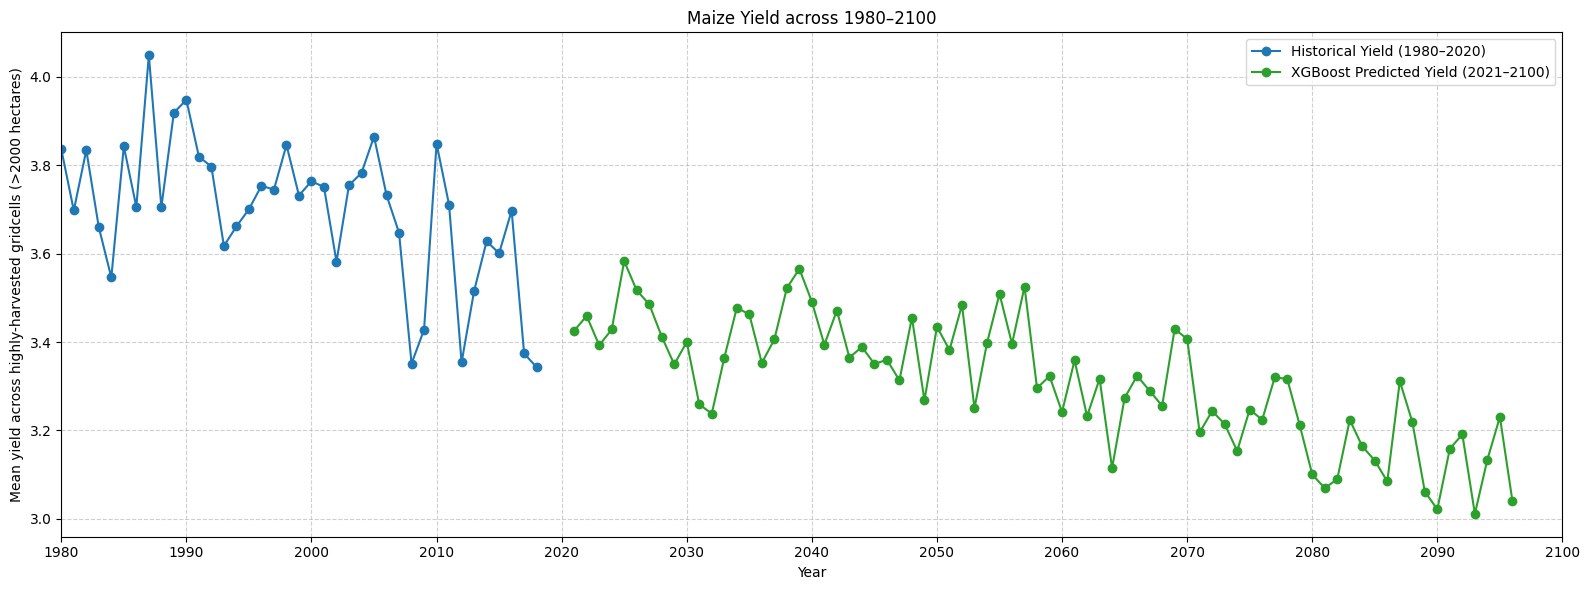

In [17]:
# Step 0: Year decoder function
def decode_year(encoded_year):
    return encoded_year - 381 + 1980

# Step 1: XGBoost predictions (2021–2100), with decoded years
xgb_pred_df = pd.DataFrame({
    "Year": decode_year(maize_test['tasmax'].loc[numeric_features_test.index, 'year']).astype(int),
    "Yield": xgb_predictions
}, index=numeric_features_test.index)

xgb_future = xgb_pred_df[(xgb_pred_df["Year"] >= 2021) & (xgb_pred_df["Year"] <= 2100)]
xgb_future_avg = xgb_future.groupby("Year", as_index=False)["Yield"].mean().rename(columns={"Yield": "Yield_pred"})

# Step 2: Historical yield (1980–2020 including validation), with decoded years
encoded_years = maize_train["tasmax"]["year"]

# Use val_mask to split years for train and val
train_years = decode_year(encoded_years[~val_mask].astype(int))
val_years = decode_year(encoded_years[val_mask].astype(int))

historical_years_all = pd.concat([train_years.reset_index(drop=True), val_years.reset_index(drop=True)])
historical_yields_all = np.concatenate([y_train, y_val])

historical_df = pd.DataFrame({
    "Year": historical_years_all,
    "Yield_hist": historical_yields_all
})
historical_avg = historical_df.groupby("Year", as_index=False)["Yield_hist"].mean()

# Step 3: Combine into full plot DataFrame (1980–2100)
all_years = pd.DataFrame({"Year": range(1980, 2101)})
historical_avg["Year"] = historical_avg["Year"].astype(int)
xgb_future_avg["Year"] = xgb_future_avg["Year"].astype(int)

plot_df = all_years.merge(historical_avg, on="Year", how="left")
plot_df = plot_df.merge(xgb_future_avg, on="Year", how="left")

# Step 4: Plot
plt.figure(figsize=(16, 6))
plt.plot(plot_df["Year"][plot_df["Yield_hist"].notna()],
         plot_df["Yield_hist"].dropna(),
         marker="o", color="tab:blue", label="Historical Yield (1980–2020)")

plt.plot(plot_df["Year"][plot_df["Yield_pred"].notna()],
         plot_df["Yield_pred"].dropna(),
         marker="o", color="tab:green", label="XGBoost Predicted Yield (2021–2100)")
plt.xlabel("Year")
plt.ylabel("Mean yield across highly-harvested gridcells (>2000 hectares)")
plt.title("Maize Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.xticks(range(1980, 2101, 10))
plt.legend()
plt.tight_layout()
plt.show()


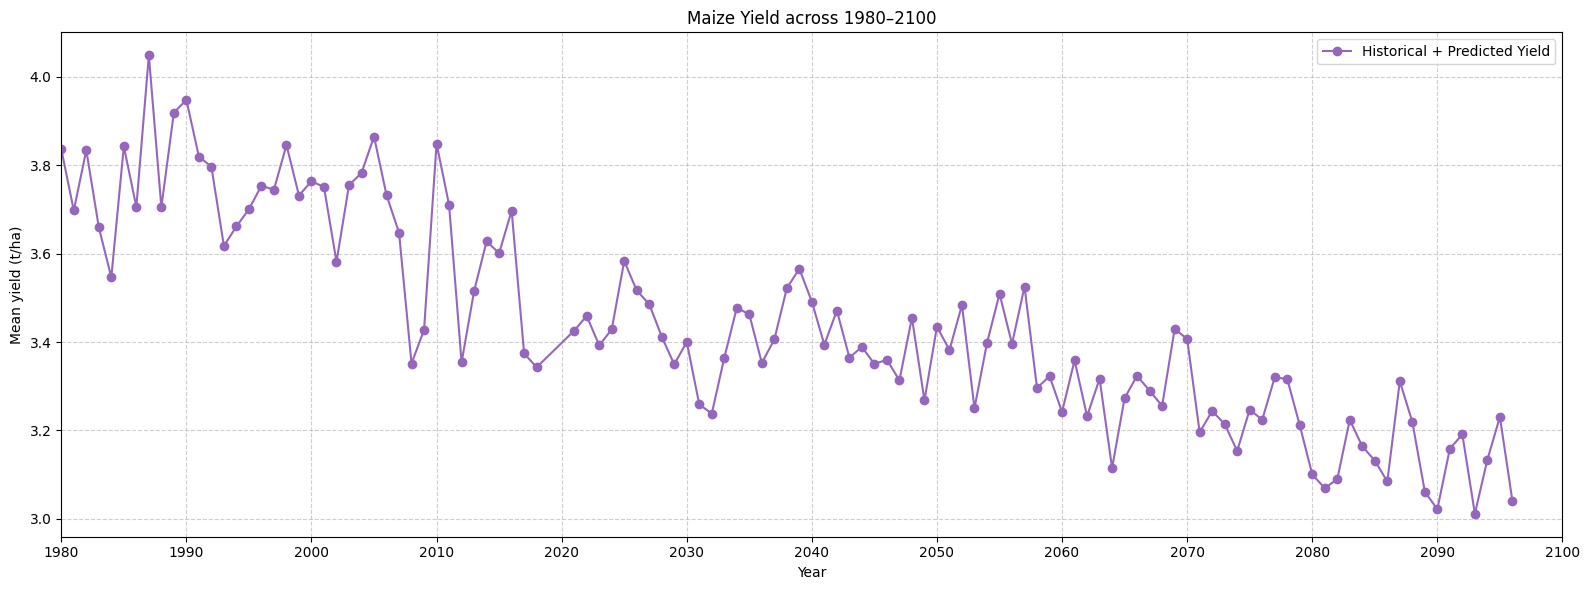

In [18]:
# Combine historical + predicted into one series
combined_yield = pd.concat([
    plot_df.set_index("Year")["Yield_hist"].dropna(),
    plot_df.set_index("Year")["Yield_pred"].dropna()
])

plt.figure(figsize=(16, 6))
plt.plot(combined_yield.index, combined_yield.values, marker="o", color="tab:purple", label="Historical + Predicted Yield")
plt.xlabel("Year")
plt.ylabel("Mean yield (t/ha)")
plt.title("Maize Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.xticks(range(1980, 2101, 10))
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/466120339.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)


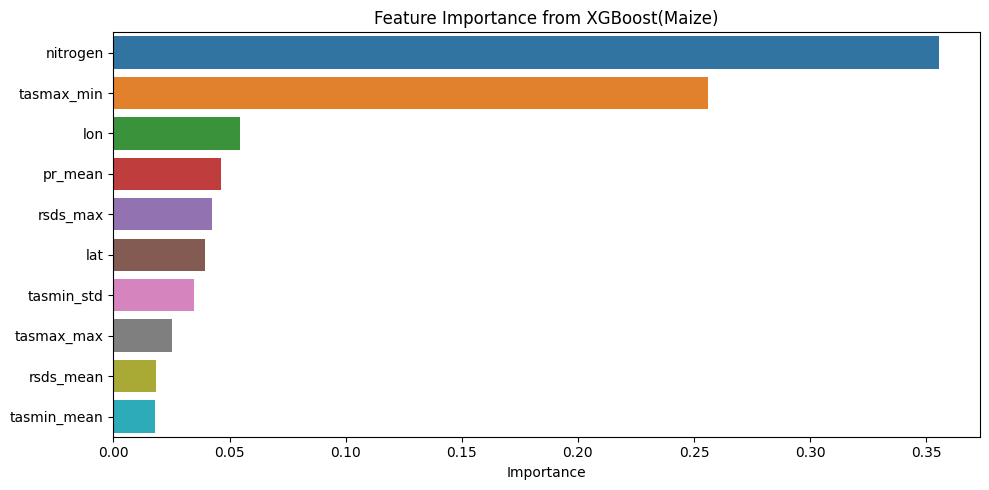

In [21]:
# Feature importance from XGBoost
importances = xgb_model.feature_importances_
features = numeric_features_maize.columns
sorted_idx = np.argsort(importances)[::-1]  # Descending order
top_idx = sorted_idx[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)
plt.title("Feature Importance from XGBoost(Maize)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [25]:
importances = xgb_model.feature_importances_
features = numeric_features_maize.columns

# Create a DataFrame of features and their importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display top N (optional)
importance_df.head(20)

,Feature,Importance
0,nitrogen,0.355403
1,tasmax_min,0.256195
2,lon,0.054419
3,pr_mean,0.046377
4,rsds_max,0.042544
5,lat,0.039273
6,tasmin_std,0.034657
7,tasmax_max,0.025069
8,rsds_mean,0.018129
9,tasmin_mean,0.018098


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


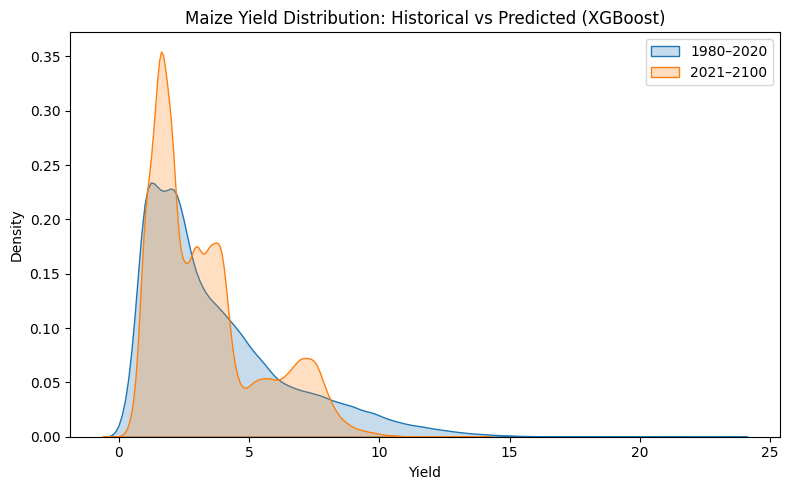

In [22]:
# Prepare historical and predicted yield DataFrames
historical_xgb_df = historical_df[["Year", "Yield_hist"]].rename(columns={"Yield_hist": "Yield"})
historical_xgb_df = historical_xgb_df[(historical_xgb_df["Year"] >= 1980) & (historical_xgb_df["Year"] <= 2020)]

future_xgb_df = xgb_pred_df[xgb_pred_df["Year"] >= 2021]

# KDE plot for yield distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(data=historical_xgb_df, x="Yield", label="1980–2020", fill=True)
sns.kdeplot(data=future_xgb_df, x="Yield", label="2021–2100", fill=True)
plt.title("Maize Yield Distribution: Historical vs Predicted (XGBoost)")
plt.xlabel("Yield")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()